### Libraries

In [43]:

import pandas as pd
import numpy as np
import sqlite3
import textman as tx
import sqlite3
from scipy.spatial.distance import pdist
from sklearn.externals import joblib
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS
#!pip install mpld3 --user
import mpld3

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
db_file='./novels.db'

### Functions

In [71]:
#define custom toolbar location
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 150);
      this.fig.toolbar.toolbar.attr("y", 400);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}

### READ IN DATA

In [8]:
with sqlite3.connect(db_file) as db:
     tfidf_small=pd.read_sql("SELECT * FROM tfidf_small", db,index_col=["bag_id","term_id"])
     vocab = pd.read_sql("select * from vocab", db, index_col='term_id')

In [9]:
TFIDF=tfidf_small.unstack()

In [44]:
dist = 1 - cosine_similarity(TFIDF) #For later use 

### Use Small TFIDF Create K-Means Clusters

In [19]:
km = KMeans(n_clusters=5,max_iter=1000)
km.fit(TFIDF)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [ ]:
#joblib.dump(km,  'doc_cluster.pkl')

#km = joblib.load('doc_cluster.pkl')

### Label Clusters Using BookName

In [11]:
with sqlite3.connect(db_file) as db:
     book_index=pd.read_sql("SELECT * FROM doc", db)

In [12]:
book_index.head()

,index,gender,nationality,date,title,text
0,0,m,a,1903,The Heart of Rome,\n\n\n\nTHE HEART OF ROME\n\n\n\n\n\n\nCHAPTER...
1,1,m,a,1903,The Log of a Cowboy,\n\nTHE LOG OF A COWBOY\n\n\n\nCHAPTER I\n\nUP...
2,2,m,b,1888,Spring Days,\n\nSPRING DAYS\n\nBY GEORGE MOORE\n\n\n\n\nPR...
3,3,m,b,1886,Muslin,\n\n\nMUSLIN\n\n\n\nI\n\n\nThe convent was sit...
4,4,m,b,1897,Dracula,\nCHAPTER 1\n\nJonathan Harker's Journal\n\n(K...


In [20]:
clusters=km.labels_.tolist()

In [21]:
book_frame = { 'title': book_index["title"].values.tolist(), 'date': book_index["date"].values.tolist(), 'cluster': clusters, 'gender': book_index["gender"].values.tolist(),'nationality':book_index["nationality"].values.tolist() }
frame = pd.DataFrame(book_frame, index = [clusters] , columns = ['title', 'date','cluster', 'gender','nationality'])

In [22]:
frame['cluster'].value_counts() #number of books per cluster (clusters from 0 to 4)

4    75
0    22
3     1
2     1
1     1
Name: cluster, dtype: int64

### Gender by Cluster 

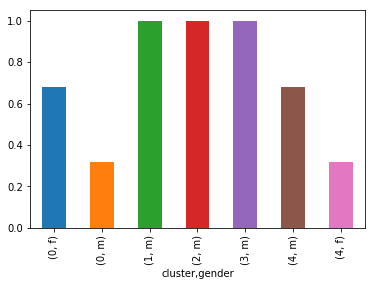

In [24]:
frame.groupby("cluster").gender.value_counts(normalize=True).plot(kind='bar')

### Nationality by Cluster

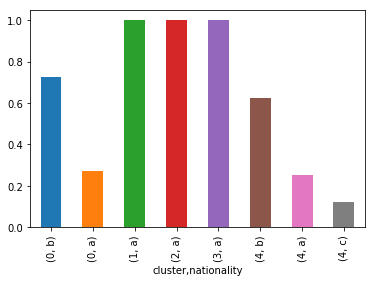

In [25]:
frame.groupby("cluster").nationality.value_counts(normalize=True).plot(kind='bar')

### Multidimensional Scaling

In [26]:
MDS()

MDS(dissimilarity='euclidean', eps=0.001, max_iter=300, metric=True,
  n_components=2, n_init=4, n_jobs=None, random_state=None, verbose=0)

In [45]:
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(dist)  # shape (n_components, n_samples)
xs, ys = pos[:, 0], pos[:, 1]

### Find the most related Term_str, book  for each cluster  

In [46]:
with sqlite3.connect(db_file) as db:
        vocab = pd.read_sql("SELECT * FROM vocab WHERE stop = 0", db, index_col='term_id')

In [47]:
vocab.head()

,term_str,n,p,port_stem,stop,df,idf,tfidf_sum,tfidf_mean,tfidf_max
term_id,,,,,,,,,,
1,aa,1,1.168000e-07,aa,0,1,2.000000,2.000000,0.020000,2.000000
2,aabstract,1,1.168000e-07,aabstract,0,1,2.000000,2.000000,0.020000,2.000000
3,aan,1,1.168000e-07,aan,0,1,2.000000,2.000000,0.020000,2.000000
4,aaron,3,3.503999e-07,aaron,0,3,1.522879,4.568636,0.045686,1.522879
5,aarons,1,1.168000e-07,aaron,0,1,2.000000,2.000000,0.020000,2.000000


In [64]:
vocab.iloc[4]["term_str"]

'aarons'

In [62]:
a.iloc[4].name[1]

63027

In [68]:
print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 


for i in range(5):
    print("Cluster %d words:" % i)
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        print(' %s' % vocab.iloc[tfidf_small.iloc[ind].name[1]]["term_str"])
    print("Cluster %d titles:" % i)
    for title in frame.ix[i]['title'].values.tolist():
        print(' %s,' % title, end='')
        print()

Top terms per cluster:

Cluster 0 words:
 attains
 dignitaries
 stück
 interpreters
 stipulate
 sturdily
Cluster 0 titles:
 Dracula,
 WeTwo,
 Home Influence,
 John Halifax,
 Basil,
 The Odd Woman,
 Uncle Tom's Cabin,
 The Witch of Prague,
 Prideand Prejudice,
 The Tenant of Wildfell Hall,
 Evelina,
 Sister Carrie,
 Alas!,
 Mary Barton,
 The Custom of the Country,
 The Unclassed,
 Vendetta,
 Sons and Lovers,
 The Marriage of William Ashe,
 The House of Mirth,
 Philothea,
 Lady Audley's Secret,
Cluster 1 words:
 aspgrain
 stipulate
 sharers
 nubbly
 reopen
 weightiest
Cluster 1 titles:
 The Last of the Mohicans,
Cluster 2 words:
 learners
 poll
 galley
 resembling
 fust
 reduplicated
Cluster 2 titles:
 The Log of a Cowboy,
Cluster 3 words:
 learners
 galley
 poll
 resembling
 slung
 reduplicated
Cluster 3 titles:
 The Outlet,
Cluster 4 words:
 woodenness
 desiccated
 stipulate
 profile
 sul
 resembling
Cluster 4 titles:
 The Heart of Rome,
 Spring Days,
 Muslin,
 Roden’s Corner,
 Darrel 

/apps/software/standard/core/anaconda/5.2.0-py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if sys.path[0] == '':


In [82]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
cluster_names = {0: 'attains,dignitaries,stück,interpreters,stipulate,sturdily', 
                 1: 'aspgrain,stipulate,sharers,nubbly,reopen,weightiest', 
                 2: 'learners,poll,galley,resembling,fust,reduplicated',
                 3: 'learners,galley,poll,resembling,slung,reduplicated', 
                 4: 'woodenness,desiccated,stipulate,profile,sul,resembling'}

In [97]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=frame["title"].values.tolist())) 
#group by cluster
groups = df.groupby('label')

#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }

svg.mpld3-figure {
margin-left: -200px;}
"""

# Plot 
fig, ax = plt.subplots(figsize=(14,6)) #set plot size

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=18, 
                     label=cluster_names[name], mec='none', 
                     color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.title]
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=10, hoffset=10, css=css)
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    
ax.legend(numpoints=1) #show legend with only one dot

mpld3.display() #show the plot

#uncomment the below to export to html
#html = mpld3.fig_to_html(fig)
#print(html)

### Let us investigate the 1~3 Cluters

In [94]:
for i in range(1,4):
    print("Cluster %d words:" % i)
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        print(' %s' % vocab.iloc[tfidf_small.iloc[ind].name[1]]["term_str"])
    print("Cluster %d titles:" % i)
    for title in frame.ix[i]['title'].values.tolist():
        print(' %s,' % title, end='')
        print()

Cluster 1 words:
 aspgrain
 stipulate
 sharers
 nubbly
 reopen
 weightiest
Cluster 1 titles:
 The Last of the Mohicans,
Cluster 2 words:
 learners
 poll
 galley
 resembling
 fust
 reduplicated
Cluster 2 titles:
 The Log of a Cowboy,
Cluster 3 words:
 learners
 galley
 poll
 resembling
 slung
 reduplicated
Cluster 3 titles:
 The Outlet,


/apps/software/standard/core/anaconda/5.2.0-py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


####  Invetigate the 3 Novels Individually with A Seperate Notebook